In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from math import *
import math

plt.style.use('seaborn')

savefigs = False

# Import Data

In [2]:
data_train = pd.read_csv("data/EMGaussian.data", header=None, sep=' ')
data_train.columns = ['x1', 'x2']

In [3]:
data_test = pd.read_csv("data/EMGaussian.test", header=None, sep=' ')
data_test.columns = ['x1', 'x2']

# K-means

In [4]:
def distance(x, y):
    return np.linalg.norm(x-y)

def assign_cluster(x, centers):
    distance_x = lambda y: np.linalg.norm(x-y)
    return np.argmin(np.apply_along_axis(distance_x, axis=1, arr = centers))

In [5]:
class K_means:
    def __init__(self, nb_centers, iter_limit = 100):
        self.nb_centers = nb_centers
        self.centers = []
        self.iter_limit = iter_limit
    def set_centers(self, centers):
        self.centers = centers
    def get_centers(self):
        return self.centers
    def init_centers(self, data):
        K = np.random.choice(np.arange(0, data.shape[0]), self.nb_centers, replace = False)
        self.centers = data.iloc[K]
    def assign_centers(self, x):
        distance_x = lambda y: np.linalg.norm(x-y)
        return np.argmin(np.apply_along_axis(distance_x, axis=1, arr = self.centers))
    def train(self, data, pr=False):
        dt_work = data.copy()
        self.init_centers(dt_work)
        i = 0
        while i < self.iter_limit:
            prev_centers = self.centers.copy()
            dt_work['c'] = np.apply_along_axis(func1d=self.assign_centers, arr=dt_work[['x1','x2']], axis=1)
            self.centers = dt_work.groupby('c').mean()
            if np.array_equal(self.centers.values, prev_centers.values):
                break
            i+=1
    def predict(self, data):
        return np.apply_along_axis(func1d=self.assign_centers, arr=data[['x1','x2']], axis=1)
    def get_full_std(self, data):
        dt_work = data.copy()
        dt_work['c'] = self.predict(data)
        return dt_work.groupby('c').cov().values.reshape(self.nb_centers, 2, 2)

In [6]:
dt_work = data_train.copy()

n_k = 4
Kmeans = K_means(n_k, iter_limit=10)
Kmeans.get_centers()
Kmeans.train(dt_work)

dt_work['Cluster'] = Kmeans.predict(dt_work)

centers = Kmeans.get_centers()

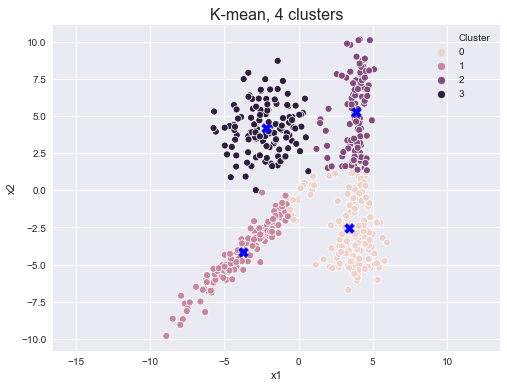

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dt_work, x='x1', y='x2', hue='Cluster')
plt.scatter(x = centers['x1'], y=centers['x2'], s=100, c='blue', marker='X')
plt.title('K-mean, {} clusters'.format(n_k), size = 16)
plt.axis('equal')
if savefigs:
    plt.savefig('figures/Kmean_{}.png'.format(n_k))

# Random initializations

In [8]:
def get_distortion(data, labels):
    dt = data.copy()
    dt['c'] = labels
    centers = dt.groupby('c').mean()
    z = pd.get_dummies(labels).values
    return np.sum(np.linalg.norm(
                np.array([data[['x1', 'x2']].values - centers.values[k] for k in range (len(centers))]),
                axis = 2)**2
           * z.T)

In [22]:
# Range of the parameter K
n_k_tab = np.arange(2, 8)

# Number of executions for each K (used n_iter=20 in report)
n_iter = 20

distortion_summary = pd.Series(index=n_k_tab)
center_distortion = pd.Series(index=n_k_tab)

for n_k in n_k_tab:
    i = 0
    distortion_tab = []
    dt_work = data_train.copy()
    all_centers = pd.DataFrame(columns=['x1', 'x2', 'distortion'])

    while i < n_iter:
        Kmeans = K_means(n_k)
        Kmeans.train(dt_work)
        labels = Kmeans.predict(dt_work)

        distortion = get_distortion(dt_work, labels)
        distortion_tab.append(get_distortion(dt_work, labels))

        centers = Kmeans.get_centers()
        centers['distortion'] = distortion

        all_centers = pd.concat((all_centers, centers))
        i+=1

    distortion_summary[n_k] = np.var(distortion_tab)

    centers_positions = all_centers.reset_index()[['x1', 'x2']]
    Kmean_centers = K_means(n_k)
    Kmean_centers.train(centers_positions, pr = True)
    center_distortion[n_k] = get_distortion(centers_positions, Kmean_centers.predict(centers_positions))

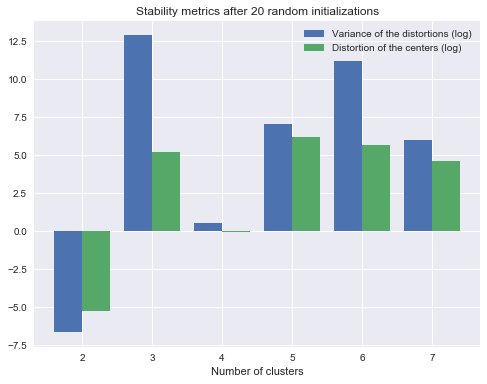

In [23]:
plt.figure(figsize=(8, 6))
plt.bar(x = n_k_tab-.2, height = np.log(distortion_summary), width = .4, label=
       "Variance of the distortions (log)")
plt.bar(x = n_k_tab+.2, height = np.log(center_distortion), width = .4, label=
       "Distortion of the centers (log)")
plt.legend(loc=0)
plt.title("Stability metrics after {} random initializations".format(n_iter))
plt.xlabel("Number of clusters")
if savefigs:
    plt.savefig("Figures/Kmean_robust_metrics.png")

# EM Algorithm

## Isotropic constraint :
$$z \in \{1;4\}, x|z={j} \sim \mathcal{N}(\mu_{j},\sigma_{j}^2I_d)$$

## Calculation of z|x :
$$ p_{\theta}(z_i=j|x_i) = \frac
{\pi_j\sigma_j^{-d}\exp(-\frac{1}{2\sigma_j^2}
(x_i-\mu_j)^T(x_i-\mu_j))
}
{\sum\limits_{{j'}=1}^{4}
\pi_{j'}\sigma_{j'}^{-d}\exp(-\frac{1}{2\sigma_{j'}^2}
(x_i-\mu_{j'})^T(x_i-\mu_{j'}))
} = \tau_i^j
$$

## M-step :
Suppose we are at step $t$.
The new parameters $\pi^{t+1}$, $\mu^{t+1}$, $\sigma^{t+1}$ are computed with the following formulas :
$$\pi_{j,t+1} = \frac
{\sum\limits_{i=1}^{n} \tau_i^j
}{n}
$$

$$
\mu_{j,t+1} = \frac
{\sum\limits_{i=1}^{n} \tau_i^j x_i
}{\sum\limits_{i=1}^{n} \tau_i^j}
$$

$$
\sigma_{j,t+1}^2= \frac
{\sum\limits_{i=1}^{n} \tau_i^j (x_i-\mu_{j,t+1})^T(x_i-\mu_{j,t+1})
}{\sum\limits_{i=1}^{n} \tau_i^j}
$$

## General case:
$$
\Sigma_{j,t+1} = \frac
{\sum\limits_{i=1}^{n} \tau_i^j (x_i-\mu_{j,t+1})(x_i-\mu_{j,t+1})^T
}{\sum\limits_{i=1}^{n} \tau_i^j}
$$

In [11]:
def p_theta_z(i, x, pi, mu, sigmas, n_k):
    '''
    Returns the likelihood of z=i|x under the assumption that the covariance matrix are proportional to the identity
    '''
    A = pi[i]*1/(sigmas[i]**2)*exp(-1/(2*sigmas[i]**2)*(x-mu[i]).T.dot(x-mu[i]))
    B = sum([pi[j]*1/(sigmas[j]**2)*exp(-1/(2*sigmas[j]**2)*(x-mu[j]).T.dot(x-mu[j])) for j in range (n_k)])
    return A/B

def p_theta_z_anisotrope(j, x, pi, mu, sigmas, n_k):
    '''
    Returns the likelihood of z=i|x for any covariance matrix
    '''
    sigma_1 = [np.linalg.inv(sigmas[u]) for u in range (n_k)]
    A = pi[j]*(np.linalg.det(sigma_1[j])**0.5)*exp(-1/2*(x-mu[j]).T.dot(sigma_1[j]).dot(x-mu[j]))
    B = sum([pi[k]*(np.linalg.det(sigma_1[k])**0.5)*exp(-1/2*(x-mu[k]).T.dot(sigma_1[k]).dot(x-mu[k])) 
             for k in range (n_k)])
    return A/B

In [12]:
def gaussian(x, mu, sigma):
    '''
    Returns the likelihood that x follows a gaussian distribution of parameters mu, sigma
    '''
    fact = 1/((2*math.pi)**2*np.linalg.det(sigma))
    x_mu = np.array([x[0],x[1]]) - mu
    return fact * exp(-1/2 * (x_mu.T.dot(np.linalg.inv(sigma).dot(x_mu))))


def log_likelihood(dt, pi, mu, sigmas, n_k):
    '''
    Returns the log likelihood of the dataset dt under the model described above, for parameters pi, mu and sigma.
    '''
    if len(sigmas.shape) == 1:
        sigmas = [s*np.eye(dt.shape[1]) for s in sigmas]
    LH = lambda x: log(sum([pi[j] * gaussian(x, mu[j], sigmas[j]) for j in range (n_k)]))
    return np.sum(np.apply_along_axis(func1d=LH, arr=dt, axis=1))

In [13]:
def plot_ellipse(ax, x, y, sigmas, nb_std = 1):
    '''
    Plots an Ellipse that is 'nb_std' standard-deviation away from the mean given a center and covariance matrix
    '''
    lambda_, v = np.linalg.eig(sigmas)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*nb_std*2, height=lambda_[1]*nb_std*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])), fill = False,
                  alpha = 1/(nb_std),
                  linewidth = 2)
    ax.add_artist(ell)

In [14]:
class EM_algorithm:
    '''
    Expectation Maximization algorithm with Kmean initialization.
    '''
    def __init__(self, data, k, eps = 1e-2, isotrope = False):
        '''
        Parameters:
        - data: dataset on which to perform the algorithm
        - k: Number of clusters
        - eps: Convergence precision 
        - isotrope: if True, the covariance matrix is kept proportionnal to the identity
        '''
        self.data = data.copy()
        self.isotrope = isotrope
        self.k = k
        self.n = self.data.shape[0]
        self.eps = eps
        
        # Initialization : First perform a Kmean to initialize tau...
        Kmeans = K_means(self.k)
        Kmeans.train(self.data)
        centers = Kmeans.get_centers()
        
        self.tau = pd.get_dummies(Kmeans.predict(dt_work)).values.astype(float)
        self.mu = centers[['x1', 'x2']].values
        self.pi = self.tau.mean(axis=0)
        if self.isotrope:
            self.sigmas = np.zeros(self.k)
        else:
            self.sigmas = Kmeans.get_full_std(self.data).reshape(self.k, 2, 2)
            
        # ...and then an M-step to initialize pi, mu and sigma.
        self.M_step()
        
    def update_pi(self):
        self.pi = np.mean(self.tau, axis = 0)
        
    def update_mu(self):
        for j in range (self.k):
            self.mu[j] = np.average(self.data[['x1', 'x2']].values, axis = 0, weights = self.tau[:,j])
        
    def update_sigmas(self):
        if self.isotrope:
            for j in range (self.k):
                vector_prod = lambda x: x.dot(x.T)
                fun = lambda x : np.linalg.norm((np.array([x[0],x[1]]) - self.mu[j]))
                self.sigmas[j] = np.sqrt(np.apply_along_axis(func1d=fun, arr=self.data[['x1', 'x2']], axis = 1).T.dot(self.tau[:,j])/sum(self.tau[:,j]))
        else:
            for j in range (self.k):
                vector_prod = lambda x: x.dot(x.T)
                fun = lambda x : vector_prod((np.array([x[0],x[1]]) - self.mu[j]).reshape(2,1))
                self.sigmas[j] = np.apply_along_axis(func1d=fun, arr=self.data[['x1', 'x2']], axis = 1).T.dot(self.tau[:,j])/sum(self.tau[:,j])

    def E_step(self):
        if self.isotrope:
            fun_j = lambda j: lambda x: p_theta_z(j, x, self.pi, self.mu, self.sigmas, self.k)
            for j in range(self.k):
                self.tau[:,j] = np.apply_along_axis(arr=self.data[['x1','x2']], func1d=fun_j(j), axis=1)
        else:
            fun_j = lambda j: lambda x: p_theta_z_anisotrope(j, x, self.pi, self.mu, self.sigmas, self.k)
            for j in range(self.k):
                self.tau[:,j] = np.apply_along_axis(arr=self.data[['x1','x2']], func1d=fun_j(j), axis=1)

                
    def M_step(self):
        self.update_pi()
        self.update_mu()
        self.update_sigmas()
        
    def run(self, max_iter=200, plot = False):
        '''
        Run the algorithm until convergence of tau with precision 'eps'. 
        If 'plot' is True or an integer 'i', plots the data with the learned parameters every 'i' iterations.
        '''
        i = 0
        while i < max_iter:
            previous_tau = self.tau.copy()
            self.E_step()
            self.M_step()
            delta_tau = np.linalg.norm(previous_tau - self.tau)
            if type(plot) == int:
                if (i % plot == 0):
                    self.plot_all()
                    plt.show()
            elif plot:
                self.plot_all()
                plt.show()
            if delta_tau < self.eps:
                break
            i+=1
        
    def predict(self):
        return np.argmax(self.tau, axis=1)
        
    def log_likelihood(self):
        '''
        Returns the log-likelihood of the data given parameters pi, mu and sigma
        '''
        return log_likelihood(self.data, self.pi , self.mu, self.sigmas, self.k)
    
    # -- Plotting functions --
    def plot_data(self, predict = True):
        if predict:
            dt = self.data.copy()
            dt['c'] = self.predict()
            fig = sns.scatterplot(data=dt, x='x1', y='x2', hue = 'c')
            fig.axis('equal')
        else:
            fig = sns.scatterplot(data=self.data, x='x1', y='x2')
            fig.axis('equal')
        return fig
    
    def plot_centers(self):
        fig = plt.scatter(x = self.mu[:, 0], y=self.mu[:, 1], s=40, c='lightgreen')
        return fig
    
    def plot_circles(self):
        x_lim = np.max(abs(self.data['x1']))
        y_lim = np.max(abs(self.data['x2']))
        u = np.linspace(-x_lim, x_lim, 400)
        v = np.linspace(-y_lim, y_lim, 400)
        u, v = np.meshgrid(u, v)
        if self.isotrope:
            ax = plt.subplot(1,1,1)
            for i in range(self.mu.shape[0]):
                plot_ellipse(ax, self.mu[i,0], self.mu[i,1], self.sigmas[i]**2*np.eye(self.k), nb_std=2)
                #plot_ellipse(ax, self.mu[i,0], self.mu[i,1], self.sigmas[i]*np.eye(self.k), nb_std=3)
        else:
            ax = plt.subplot(1,1,1)
            for i in range(self.mu.shape[0]):
                plot_ellipse(ax, self.mu[i,0], self.mu[i,1], self.sigmas[i], nb_std=2)
                #plot_ellipse(ax, self.mu[i,0], self.mu[i,1], self.sigmas[i], nb_std=3)

    def plot_all(self):
        if self.isotrope:
            mode = 'Isotropic'
        else:
            mode = 'Anisotropic'
        plt.figure()
        plt.title('{}, Log-likelihood: {}'.format(mode, round(self.log_likelihood(),2)), size = 16)
        plt.xlabel('x1', size = 16)
        plt.ylabel('x2', size = 16)
        self.plot_data()
        self.plot_centers()
        self.plot_circles()

# Train data

In [15]:
EM_iso = EM_algorithm(data = data_train, isotrope=True, k=4, eps=1e-1)
EM_iso.run(plot = False)

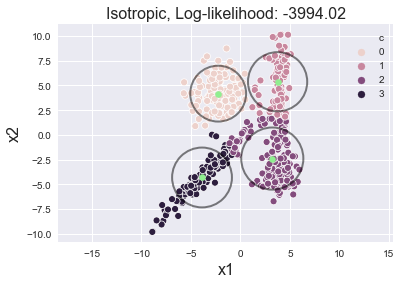

In [16]:
EM_iso.plot_all()
if savefigs:
    plt.savefig("Figures/Iso_train.png")

In [17]:
EM_aniso = EM_algorithm(data = data_train, isotrope=False, k=4, eps=1e-1)
EM_aniso.run(plot = False)

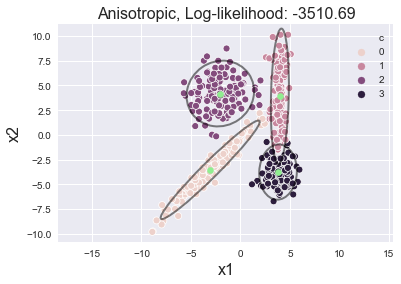

In [18]:
EM_aniso.plot_all()
if savefigs:
    plt.savefig("Figures/Aniso_train.png")

# Test Data

In [19]:
# Isotropic 
EM_iso_test = EM_iso
EM_iso_test.data= data_test
print("Log-likelihood, Isotropic, Test Data : ", round(EM_iso_test.log_likelihood(), 2))

# Anisotropic 
EM_aniso_test = EM_aniso
EM_aniso_test.data= data_test
print("Log-likelihood, Anisotropic, Test Data : ", round(EM_aniso_test.log_likelihood(), 2))

Log-likelihood, Isotropic, Test Data :  -3985.96
Log-likelihood, Anisotropic, Test Data :  -3613.76
